In [55]:
%matplotlib inline

import numpy as np
import scipy as sc
from scipy import io

from numpy import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm

We load the dataset and we extrapolate the matrix we are interested in

In [56]:
data = io.loadmat('69dataset.mat')
X = data['X']
Y = data['Y']
prior = data['prior']

We define a normalization function which subtracts the mean of every sample in each matrix and divides it by the standard deviation 

In [57]:
def normalize(data):
    data = np.transpose(data)
    output = []
    for row in data:
        this_row = row
        mean = np.mean(this_row)
        std = np.std(this_row)
        if std == 0:
            normalized = np.zeros(len(this_row))
        else:
            normalized = (this_row-mean)/std
        output.append(normalized.astype(float))
        
    output = np.transpose(output)
    return np.asarray(output)

We define another function to split the matrices in the training set and the test set

In [58]:
def split_into_train_test(data, train_per):
    length = len(data)
    train_rows = (int)(train_per * length)
    random.shuffle(data)
    train = data[:train_rows]
    test = data[train_rows:]
    
    return train, test

We apply the function we built to our matrices

In [59]:
# normalize the data
normalized_x = normalize(X)
normalized_y = normalize(Y)
prior = normalize(prior)

# make training and test sets of the normalize data
train_x, test_x = split_into_train_test(normalized_x, .8)
train_y, test_y = split_into_train_test(normalized_y, .8)

### Approach 1: discriminative model

In the first approach we will use a simple linear regression model to reconstruct the images from the voxel values. To do so we first compute the weights and we store them in the matrix B. We use the ridge regression model as this model is indicated when there is high multicollinearity in the predictior variables . 

In [60]:
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.cm as cm

We define the variables we will use in the formula to copmute the weights matrix B

In [61]:
train_yT=np.transpose(train_y) ##we create a transposed matrix of the train_y matrix
l=10**-6 ##we set our lambda variable
I=np.identity(3092) ##we create the identity matrix 

We calculate the B matrix. We divide the formula in 2 steps for clarity

In [62]:
C=inv(np.dot(train_yT,train_y)+l*I) ##we compute the first part of the ridge regression for clarity
B=np.dot(C,np.dot(train_yT,train_x)) ##we find the weights with the ridge regression

Now we can reconstruct our images.

In [63]:
yRecon1= np.dot(Y,B) ##we reconstruct the images from the voxel matrix and the matrix of weights B

Now we can plot the original images, and the reconstructed images to see how our model performs

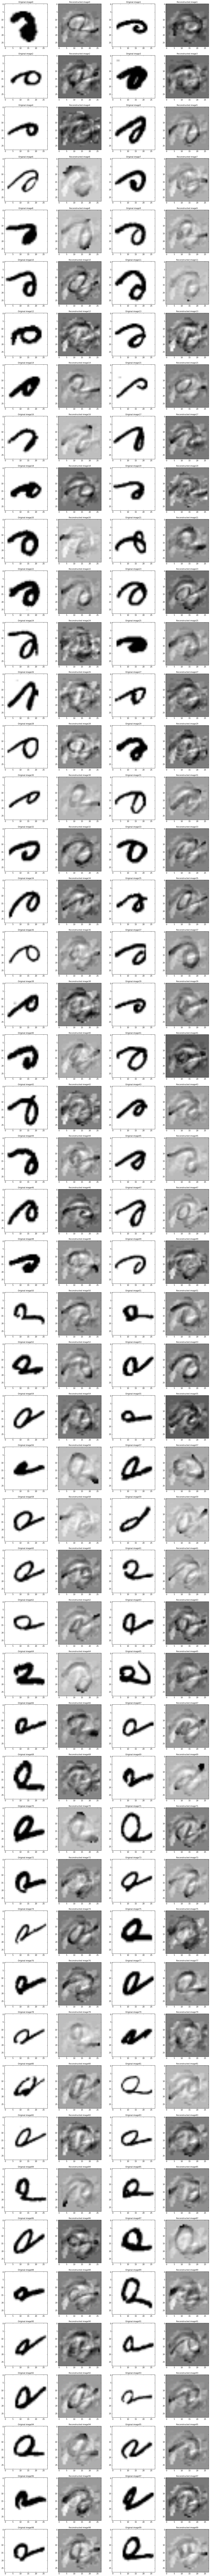

In [64]:
a=1
b=1 
plt.figure(a,figsize=(20,500))

for i in range(0,99,2):
    
    plt.subplot(100,4,a)
    plt.imshow(X[i].reshape(28, 28),cmap=cm.gray_r)
    plt.title("Original image"+str(i),fontsize=10)
    a=a+1
    plt.subplot(100,4,a)
    plt.imshow(yRecon1[i].reshape(28, 28),cmap=cm.gray_r)
    plt.title("Reconstructed image"+str(i),fontsize=10)
    a=a+1
    if b>100:
        break
    plt.subplot(100,4,a)
    plt.imshow(X[b].reshape(28, 28),cmap=cm.gray_r)
    plt.title("Original image"+str(b),fontsize=10)
    a=a+1
    plt.subplot(100,4,a)
    plt.imshow(yRecon1[b].reshape(28, 28),cmap=cm.gray_r)
    plt.title("Reconstructed image"+str(b),fontsize=10)
    a=a+1
    b=b+2
plt.show()

As we see from the plotted images , in some cases the reconstructed images of our model are very close to the original image. On the other hand in many cases the reconstruction is just an undefined mix of pixel of different shades of gray.

### Approach 2: generative model and Bayes' rule
blablabla

In [65]:
lamb = 10**-6
nPixels = 784
I = np.identity(nPixels)

first = np.dot(np.transpose(train_x), train_x)
second = first + lamb*I
third = np.linalg.inv(second)
fourth = np.dot(third, np.transpose(train_x))
B = np.dot(fourth, train_y)

print("B is computed.")

B is computed.


In [66]:
first = np.dot(np.transpose(prior), prior)
sigPrior = first / (len(prior)-1)
sigPrior[np.diag_indices_from(sigPrior)] += 10**-6 # regularize

print("Sigma prior is computed.")

Sigma prior is computed.


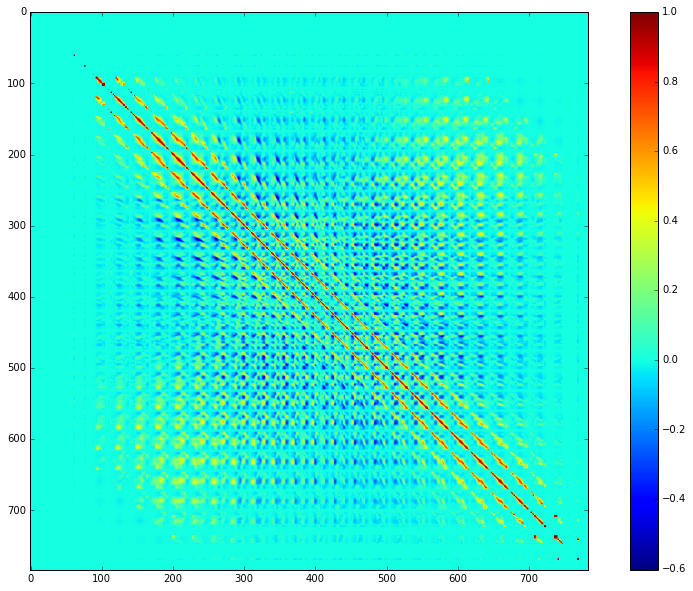

In [67]:
plt.figure(1, figsize=(15,10))

cax = plt.imshow(sigPrior)
plt.colorbar(cax)

Explanation of above figure

### Question 3: Reconstruction

In [68]:
nVoxels = 3092
I = np.identity(nVoxels)
sig = (10**-3)*I

first = np.dot(B, np.linalg.inv(sig))
second = np.dot(first, np.transpose(B))
third = np.linalg.inv(sigPrior) + second
fourth = np.linalg.inv(third)
fifth = np.dot(fourth, B)
muPost = np.dot(fifth, np.linalg.inv(sig))

In [69]:
def denormalize(original, data):
    original = np.transpose(original.astype(float))
    data = np.transpose(data.astype(float))
    
    output = []
    for row_ori, row_data in zip(original, data):
        mean = np.mean(row_ori)
        std = np.std(row_ori)
        row_out = row_data * std + mean
        
        output.append(row_out.astype(float))
        
    output = np.transpose(output)
    return output   

In [70]:
out = np.dot(muPost, np.transpose(test_y))
out = np.transpose(out)
out = denormalize(test_y, out)

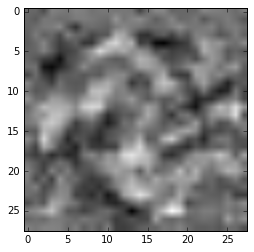

In [71]:
plt.imshow(out[3].reshape(28, 28), cmap=cm.gray_r)